<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <center><h1 style="font-size: 50px; color: white; text-shadow: 0 0 5px black, 0 0 5px black;"><b>2. Plane Detector</b></h1></center>
    <center><h1 style="font-size: 30px; color: white;  text-shadow: 0 0 5px black, 0 0 5px black;">Computer Vision</h1></center>
    <br>
    <br>
    <br>
    <br>
    <br>
    <div style="color: white; margin-left:  5%; font-size: 20px;">
        <p>Realizado por: </p>
        <ul>
            <li>Beatriz Santos, nº 108593</li>
            <li>João Ferreira, nº 88639</li>
            <li>Rodrigo Sarroeira, nº 92761</li>
        </ul>
    </div>        
    <br>
    <br>
    <br><br></div>

In [45]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from mpl_toolkits.axes_grid1 import ImageGrid

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">1. Show images</h1>
</div>

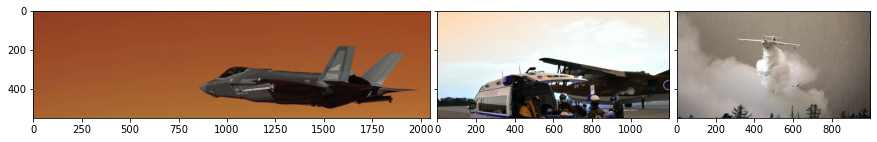

In [47]:
im1 = cv2.imread(f"images/dataset/000aa01b25574f28b654718db0700f72.jpg")
im2 = cv2.imread(f"images/dataset/000e7662268a1071827c5a8663e773f9.jpg")
im3 = cv2.imread(f"images/dataset/000ec980b5b17156a55093b4bd6004ab.jpg")

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1)

for ax, im in zip(grid, [im1, im2, im3]):
    ax.imshow(im, )

plt.show()

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">2. Define Model</h1>
</div>

In [48]:
# Paths to models and configs
MODEL_FILE = "MobileNet/frozen_inference_graph.pb"
CONFIG_FILE = "MobileNet/ssd_mobilenet_v2_coco_2018_03_29.pbtxt.txt"
CLASS_FILE = "MobileNet/object_detection_classes_coco.txt"

# Class names
with open(CLASS_FILE, 'r') as f:
    class_names = f.read().split('\n')

# Define threshold
CONFIDENCE_THRESHOLD = 0.5

# Load model
model = cv2.dnn.readNet(model=MODEL_FILE, config=CONFIG_FILE, framework="TensorFlow")

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">3. Execute Model</h1>
</div>

In [51]:
# https://modelzoo.co/  OR  YOLO3

def plane_detector(model, trust, class_names):
    images = os.listdir("images/dataset")
    n_images = len(images)
    n_identified = 0
    
    for idx, image_path in enumerate(images[:50]):
        if idx % 1000 == 0:
            print(round(idx/n_images*100),"%")
        if ".jpg" in image_path:
            img = cv2.imread(f"images/dataset/{image_path}")
            img_height, img_width, channels = img.shape
            blob = cv2.dnn.blobFromImage(image=img, size=(300, 300), swapRB=True)
            model.setInput(blob)
            output = model.forward()
            
            found = pd.DataFrame(columns=["filename","width","height","class","xmin","ymin","xmax","ymax"])
            for detection in output[0, 0, :, :]:
                if detection[1] == 5:
                    if detection[2] > trust:
                        class_name = class_names[int(detection[1]) - 1]
                        xmin, ymin = int(detection[3] * img_width), int(detection[4] * img_height)
                        width, height = xmin + int(detection[5] * img_width), ymin + int(detection[6] * img_height)
                        xmax, ymax = xmin + width, ymin + height
                        row = pd.DataFrame({"filename": [image_path[:-4]], 
                                            "width": width, 
                                            "height": height,
                                            "class": class_name,
                                            "xmin": xmin, 
                                            "ymin": ymin, 
                                            "xmax":xmax, 
                                            "ymax": ymax})
                        found = pd.concat([found, row])
                        n_identified+=1
            if len(found):
                found.to_csv(f"images/dataset2/{image_path[:-4]}.csv")
    print(f"\n-> {round(n_images/2)} images \n-> {n_identified} airplanes identified.")


In [52]:
plane_detector(model, CONFIDENCE_THRESHOLD, class_names)

0 %
2 %
3 %
5 %
7 %
8 %
10 %
12 %
13 %
15 %
17 %
18 %
20 %
22 %
23 %
25 %
27 %
28 %
30 %
32 %
33 %
35 %
37 %
38 %
40 %
42 %
43 %
45 %
47 %
48 %
50 %
52 %
53 %
55 %
57 %
58 %
60 %
62 %
63 %
65 %
67 %
68 %
70 %
72 %
73 %
75 %
77 %
78 %
80 %
82 %
83 %
85 %
87 %
88 %
90 %
92 %
93 %
95 %
97 %
98 %
100 %

-> 9004 images 
-> 7300 airplanes identified.


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">4. Evaluation</h1>
</div>

### 4.1 Intersection over Union (IoU)

In [92]:
# Function to calculate the intersection over union

def IoU(boxA, boxB):

    xA = max(boxA["xmin"], boxB["xmin"])
    xB = min(boxA["xmax"], boxB["xmax"])
    yA = max(boxA["ymin"], boxB["ymin"])
    yB = min(boxA["ymax"], boxB["ymax"])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # Area of both boxes
    boxAArea = (boxA["xmax"] - boxA["xmin"] + 1) * (boxA["ymax"] - boxA["ymin"] + 1)
    boxBArea = (boxB["xmax"] - boxB["xmin"] + 1) * (boxB["ymax"] - boxB["ymin"] + 1)
   
    return interArea / float(boxAArea + boxBArea - interArea)

In [95]:
def mean_IoU(actual_path, predicted_path):
    IoU_list = []
    n_found = 0 
    n_real = 0
    for csv_path in os.listdir(predicted_path):
        actual = pd.read_csv(actual_path + csv_path)
        predicted = pd.read_csv(predicted_path + csv_path)
        n_found += len(predicted)
        n_real += len(actual)
        if len(predicted) and len(actual):
            for idx1 in range(len(predicted)):
                IoU_combo = []
                for idx2 in range(len(actual)):
                    IoU_combo.append(IoU(predicted.iloc[idx1], actual.iloc[idx2]))
                if IoU_combo:
                    IoU_list.append(max(IoU_combo))
        
    return np.mean(IoU_list), IoU_list, n_found, n_real

In [96]:
mean_iou, iou_list, n_found, n_real = mean_IoU("images/dataset/", "images/dataset2/")
mean_iou

0.2502320993449123

### 4.2 Precision and Recall 

In [97]:
TP = sum([iou >= 0.5 for iou in iou_list])
FP = sum([iou < 0.5 for iou in iou_list])
FN = n_real - n_found

print(f"TP: {TP}\nFP: {FP}\nFN: {FN}")

TP: 1159
FP: 6141
FN: 2055


In [98]:
precision = TP / (TP + FP)
print("Precision = ", precision)

Precision =  0.15876712328767123


In [99]:
recall = TP / (TP+FN)
print("Recall =", recall)

Recall = 0.36060983198506535
